In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import akantu as aka
import numpy as np
import matplotlib.pyplot as plt

from contact_mechanics_internodes import ContactMechanicsInternodes
from helper import plot_mesh, write_solution

In [5]:
mesh_file = 'mesh/contact2d_circle.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.2, aka._y), 'secondary_fixed')

# Get positions of all nodes, surface connectivity and candidate nodes
nodal_positions = mesh.getNodes()
surface_connectivity = mesh.getConnectivity(aka._segment_2)
nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()
external_force = model.getExternalForce()
nodal_displacements = model.getDisplacement()
nodes_blocked = model.getBlockedDOFs()

model.assembleMass()
M = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('M')).toarray()

model.assembleStiffnessMatrix()
K = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('K')).toarray()

E = model.getMaterial(0).getReal("E")

# Set initial conditions
internodes_model = ContactMechanicsInternodes(spatial_dimension, nodal_positions, nodal_displacements, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary, nodes_blocked, external_force, M, K, E)

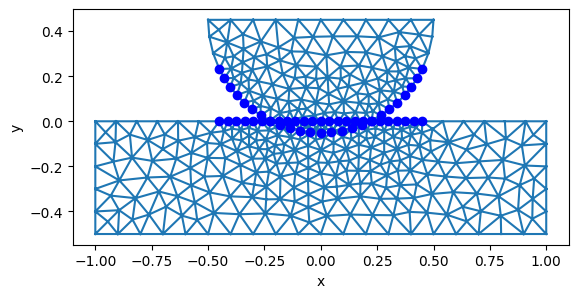

----> Starting iteration 1 <----


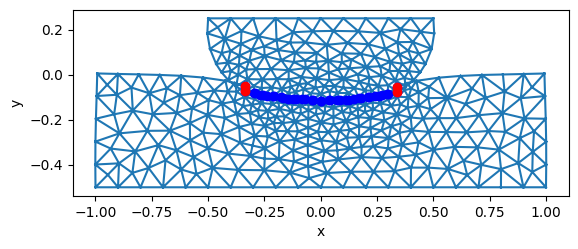

----> Starting iteration 2 <----


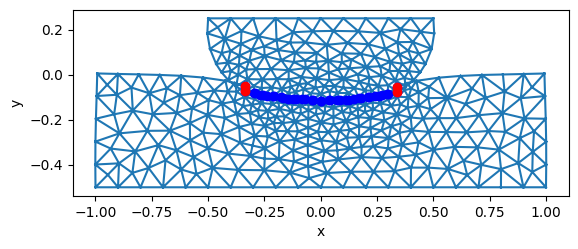

----> Starting iteration 3 <----


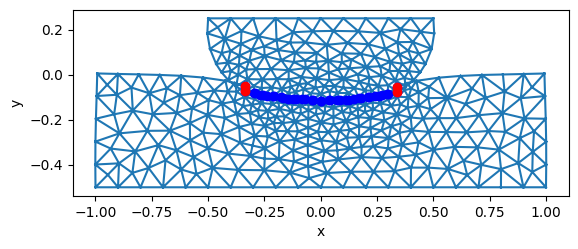

----> Starting iteration 4 <----


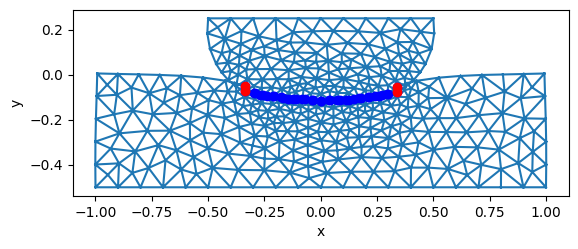

----> Starting iteration 5 <----


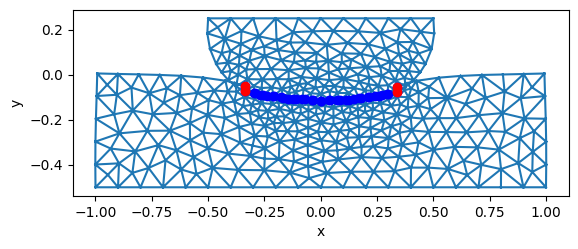

----> Starting iteration 6 <----


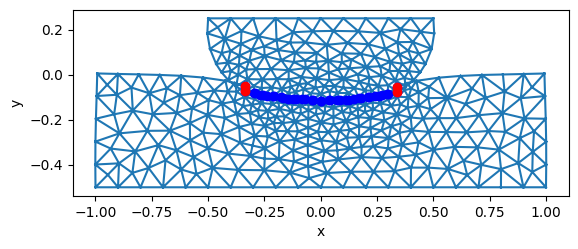

----> Starting iteration 7 <----


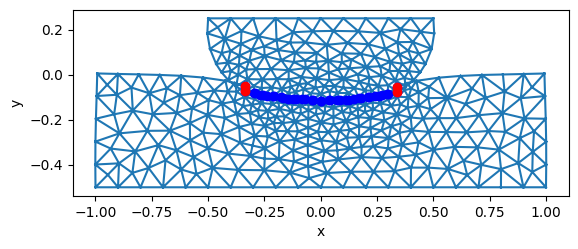

----> Starting iteration 8 <----


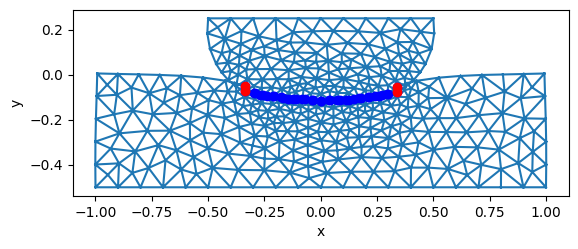

----> Starting iteration 9 <----


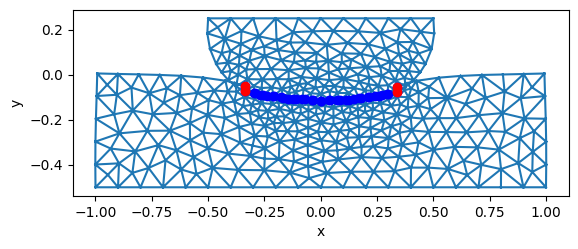

----> Starting iteration 10 <----


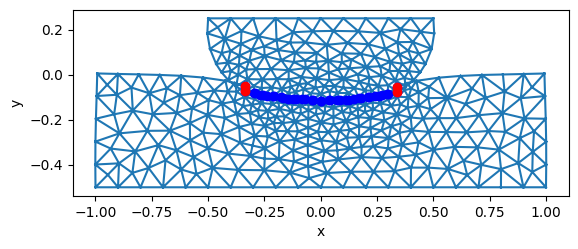

In [6]:
# Plot initial configuration
plot_mesh(internodes_model.nodal_positions, mesh.getConnectivity(aka._triangle_3),
    np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary))

max_iter = 10
for i in range(max_iter):
    print("----> Starting iteration", i+1, "<----")

    # Find the interface nodes
    internodes_model.find_interface_nodes()
    
    # Assemble model
    internodes_model.assemble_full_model()

    # Solve model
    displacements, lambdas = internodes_model.solve_direct()

    # Update the interface nodes and check if it converged
    converged, nodes_added_primary, nodes_added_secondary, nodes_dumped_primary, nodes_dumped_secondary = internodes_model.update_interface(displacements, lambdas, return_changes=True)

    # Plot the obtained solution
    plot_mesh(internodes_model.nodal_positions + displacements,
        mesh.getConnectivity(aka._triangle_3),
        np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary),
        np.union1d(nodes_added_primary, nodes_added_secondary),
        np.union1d(nodes_dumped_primary, nodes_dumped_secondary))

    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break

In [72]:
nodal_positions_new = internodes_model.nodal_positions + displacements
write_solution("mesh/contact2d_circle.msh", nodal_positions_new)

In [11]:
mesh_file = 'mesh/contact2d_circle_solved.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.2, aka._y), 'secondary_fixed')

# Get positions of all nodes, surface connectivity and candidate nodes
nodal_positions = mesh.getNodes()
surface_connectivity = mesh.getConnectivity(aka._segment_2)
nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()
external_force = model.getExternalForce()
nodal_displacements = model.getDisplacement()
nodes_blocked = model.getBlockedDOFs()

model.assembleMass()
M = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('M')).toarray()

model.assembleStiffnessMatrix()
K = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('K')).toarray()

E = model.getMaterial(0).getReal("E")

# Set initial conditions
internodes_model = ContactMechanicsInternodes(spatial_dimension, nodal_positions, nodal_displacements, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary, nodes_blocked, external_force, M, K, E)

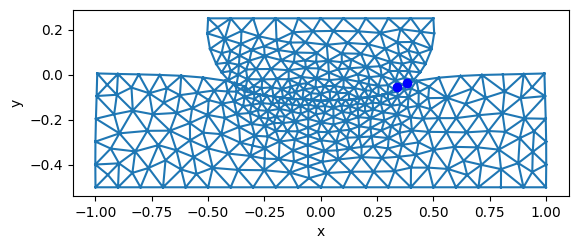

In [57]:
plot_mesh(internodes_model.nodal_positions,
        mesh.getConnectivity(aka._triangle_3),
        [39, 40]
)

In [35]:
internodes_model.find_interface_nodes()

In [36]:
print(internodes_model.nodes_candidate_primary)
print(internodes_model.nodes_interface_primary)

[ 3  4 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61]
[ 3  4 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61]


In [40]:
nodal_positions[8]

array([-0.46445132,  0.04749768])

In [38]:
print(internodes_model.nodes_candidate_secondary)
print(internodes_model.nodes_interface_secondary)

[ 8  9 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98
 99]
[77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


In [42]:
from contact_mechanics_internodes import compute_normals, find_penetration_nodes, find_interface_nodes, construct_interpolation_matrix

In [21]:
positions_candidate_primary = internodes_model.nodal_positions[internodes_model.nodes_candidate_primary]
positions_candidate_secondary = internodes_model.nodal_positions[internodes_model.nodes_candidate_secondary]

In [22]:
normals_candidate_primary = compute_normals(internodes_model.nodal_positions, internodes_model.nodes_candidate_primary, internodes_model.connectivity_candidate_primary, 2)
normals_candidate_secondary = compute_normals(internodes_model.nodal_positions, internodes_model.nodes_candidate_secondary, internodes_model.connectivity_candidate_secondary, 2)

In [62]:
find_penetration_nodes(
            positions_candidate_primary,
            positions_candidate_secondary,
            normals_candidate_primary,
            normals_candidate_secondary,
        )

(array([False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True]),
 array([False, False, False, False,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False]))

In [43]:
(
        rbf_radius_parameters_primary,
        rbf_radius_parameters_secondary,
        nodes_interface_primary_mask,
        nodes_interface_secondary_mask,
) = find_interface_nodes(positions_candidate_primary, positions_candidate_secondary)


In [45]:
nodes_interface_secondary_mask

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [49]:
positions_interface_primary = positions_candidate_primary[nodes_interface_primary_mask]
positions_interface_secondary = positions_candidate_secondary[nodes_interface_secondary_mask]


R12 = construct_interpolation_matrix(
    positions_interface_primary,
    positions_interface_secondary,
    rbf_radius_parameters_secondary,
)
R21 = construct_interpolation_matrix(
    positions_interface_secondary,
    positions_interface_primary,
    rbf_radius_parameters_primary,
)

# Determine the size of the nodal gaps on interface
nodal_gaps_primary = (
    R12 * positions_interface_secondary - positions_interface_primary
)
nodal_gaps_secondary = (
    R21 * positions_interface_primary - positions_interface_secondary
)

In [56]:
nodes_candidate_primary

array([ 3,  4, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61], dtype=uint32)

In [58]:
positions_interface_primary[2:4]

array([[ 0.3826455 , -0.03771623],
       [ 0.33953735, -0.05324299]])

In [60]:
nodal_gaps_primary[2:4]

array([[ 0.00508648, -0.00806521],
       [ 0.00824802, -0.01780437]])

In [61]:
np.sum(nodal_gaps_primary[2:4] * normals_candidate_primary[2:4], axis=1)

array([-0.00918931, -0.01958232])